In [1]:
import torch
from numpy.ma.core import size
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import FFN_Sin
from data_reader import SingleImageDataset

In [2]:
img_path = r'data/'

device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

Using cuda device


In [3]:
lr = 1e-4
b_size = 128

In [10]:
net = FFN_Sin().to(device)

# Data loader
dataset = SingleImageDataset(img_path + 'image.png')
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# We are training the network for pixels,
# so will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# Optimizer and number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
NUM_EPOCHS = 1000

In [11]:
loss_values = []

# train and store loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"]
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1

      ### Assemble coord from x and y, pass to net, compute loss
      coord = torch.stack((x, y), dim=-1).to(device)
      pred = net(coord)
      loss = criterion(pred, actual.float().to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  # Track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")

torch.save(net.state_dict(), img_path+'save_model.pt')

Epoch [1/1000], Loss: 0.004199814051389694
Epoch [2/1000], Loss: 0.004346787231042981
Epoch [3/1000], Loss: 0.0043869842775166035
Epoch [4/1000], Loss: 0.004442576784640551
Epoch [5/1000], Loss: 0.004455795045942068
Epoch [6/1000], Loss: 0.004467376119767626
Epoch [7/1000], Loss: 0.004475799588752645
Epoch [8/1000], Loss: 0.004492987820412964
Epoch [9/1000], Loss: 0.004492496968143516
Epoch [10/1000], Loss: 0.004502800991758704
Epoch [11/1000], Loss: 0.0045014533891596575
Epoch [12/1000], Loss: 0.004476437849613528
Epoch [13/1000], Loss: 0.004456962888630537
Epoch [14/1000], Loss: 0.004449682642838785
Epoch [15/1000], Loss: 0.004470434101919333
Epoch [16/1000], Loss: 0.004476367903407663
Epoch [17/1000], Loss: 0.0045037683756912455
Epoch [18/1000], Loss: 0.004556327230400509
Epoch [19/1000], Loss: 0.004597332524625878
Epoch [20/1000], Loss: 0.004644837672822177
Epoch [21/1000], Loss: 0.004666779855532306
Epoch [22/1000], Loss: 0.004683768694204363
Epoch [23/1000], Loss: 0.0047157301931

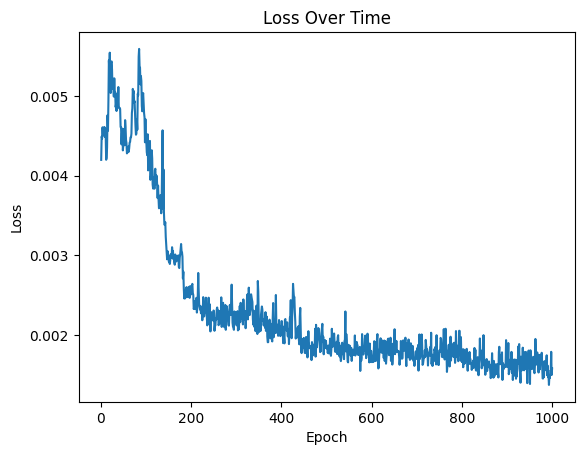

In [12]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()

In [13]:
model_path = img_path + 'save_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN_Sin(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): Sin()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Sin()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Sin()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

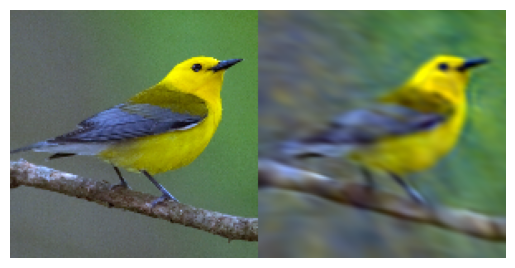

In [14]:
from torchvision.io import read_image

img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pred = net(coord.to(device))

    pred_image[:, y.item(), x.item()] = pred*255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

In [ ]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
channels, height, width = pred_image.shape

# initialize the outpainted image
outpainted_image = torch.zeros(channels, height + 2*20, width + 2*20)

for x in range(outpainted_image.shape[2]):
  for y in range(outpainted_image.shape[1]):

    x_ = torch.tensor((x - 20) / dataset.w)
    y_ = torch.tensor((y - 20) / dataset.h)

    coord = torch.stack((x_, y_), dim=-1)

    pred = net(coord.to(device))

    outpainted_image[:, y, x] = 255*pred

outpainted_image = torch.clip(outpainted_image, 0, 255).type(torch.uint8)

fig, ax = plt.subplots()
ax.imshow(outpainted_image.permute(1, 2, 0))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()